In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%matplotlib inline

2024-03-06 10:51:01.041846: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 10:51:01.064790: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 10:51:01.064814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 10:51:01.064830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 10:51:01.068876: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 10:51:01.069191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Get in dataset
data_features_test = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/csvDataFeaturesTest.csv", sep=";")

# Take out only data corresponing to attacks and remove the column labelling it as an attack
data_features_attacks = data_features_test.to_numpy()[238279:, :-1]
print(np.count_nonzero(np.isnan(data_features_attacks)))
# Set negative values to 0
data_features_attacks = np.where(data_features_attacks >= 0, data_features_attacks, 0)
data_features_attacks = data_features_attacks.reshape((9999,21,1)).astype('float32')

0


In [3]:
# based on Austrian dataset
batch_size = 64
features = 21
# what is sequence length actually representing here
seq_length = 5

In [4]:
# shuffle prevents model from getting stuck in local minima when solving the loss function
train_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[:9000]).shuffle(10000).batch(batch_size))

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    # LSTM hidden layer with 100 memory units
    model.add(tf.keras.layers.LSTM(200, input_shape = (seq_length, features), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    model.add(tf.keras.layers.ReLU())
    # dropout layer with a probability of 20
    # model.add(tf.keras.layers.Dropout(0.2))
    # output dense (fully connected) layer
    model.add(tf.keras.layers.Dense(features, activation="tanh"))
    return model

In [6]:
generator = make_generator_model()
# what do we want to the generator to output? One packet at a time? One attack at a time?
# what to use as noise - what kind of dimension?
# BGAN does [batch_size x seq_length, features]
# LSTM expects sequences of the form [samples, time steps, features]
noise = tf.random.normal((batch_size, seq_length, features))
generated_data_untrained = generator(noise, training=False)
generated_data_untrained.get_shape()

TensorShape([64, 21])

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(200, input_shape=(21,1), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    # model.add(tf.keras.layers.Dropout(0.2))
    # what should the units of this dense layer be?
    # seems like it outputs one value >0 for real data and <0 for fake data
    # for each item in the batch
    model.add(tf.keras.layers.Dense(1, activation="tanh"))
    return model

In [8]:
discriminator = make_discriminator_model()
decision_untrained = discriminator(generated_data_untrained)
# decision_untrained

### Binary Cross Entropy

$$ H_p(q) = -\frac{1}{N} \Sigma_{i=1}^N y_i log(p(y_i)) + (1-y_i) log(1-p(y_i)) $$

### BGAN Losses

$$ D_{loss} = \frac{1}{m} \Sigma_{i=1}^m [logD(x_i) + log(1-D(G(z_i)))] $$

$$ G_{loss} = \frac{1}{m} \Sigma_{i=1}^m [log(1-D(G(z_i)))] $$

In [9]:
# define losses (this will change)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=True means models prediction represents a value [-inf, inf]

In [10]:
def discriminator_loss(real_data, fake_data):
    real_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_loss + fake_loss
    return total_loss

    # BGAN loss
    # loss = tf.reduce_mean(tf.math.log(real_data) + tf.math.log(1 - fake_data), axis=None)
    # if tf.math.is_nan(loss):
    #     return 0.0
    # return loss

In [11]:
def generator_loss(fake_data):
    return cross_entropy(tf.ones_like(fake_data), fake_data)

    # BGAN loss
    # loss = tf.reduce_mean(tf.math.log(1 - fake_data))
    # if tf.math.is_nan(loss):
    #     return 0.0
    # return loss

In [12]:
generator_optimiser = tf.keras.optimizers.Adam(1e-4)
discriminator_optimiser = tf.keras.optimizers.Adam(1e-4)

In [13]:
@tf.function
def train_step(data):
    dlosses = []
    glosses = []
    # generate samples from the random space
    noise = tf.random.normal((batch_size, seq_length, features))

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_data = generator(noise, training=True)

        real_data = discriminator(data, training=True)
        fake_data = discriminator(generated_data, training=True)

        gloss = generator_loss(fake_data)
        dloss = discriminator_loss(real_data, fake_data)
        dlosses.append(dloss)
        glosses.append(gloss)

    generator_gradients = generator_tape.gradient(gloss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(dloss, discriminator.trainable_variables)

    generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimiser.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return dloss, gloss

In [14]:
noise = tf.random.normal((batch_size, seq_length, features))

In [15]:
epochs = 50

In [16]:
def train(dataset, epochs):
    predictions = np.array([])
    dlosses = []
    glosses = []

    for epoch in range(epochs):
        
        # maybe add another loop for more training rounds
        for data_batch in dataset:
            dloss, gloss = train_step(data_batch)
            dlosses.append(dloss)
            glosses.append(gloss)

        prediction = generator(noise, training=False)
        predictions = np.append(predictions, prediction)

    return predictions, dlosses, glosses

In [17]:
preds, dlosses, glosses = train(train_dataset, epochs=epochs)

In [18]:
preds = preds.reshape(batch_size*epochs, features)
preds[0]

array([ 0.51704866,  0.66362411,  0.63458341,  0.51180261,  0.59374011,
        0.57412297,  0.56056577,  0.56785858,  0.71656501,  0.57667089,
        0.72677553,  0.68252438,  0.75367993,  0.24159674,  0.5537231 ,
        0.521038  ,  0.7389878 , -0.08529909, -0.19035658, -0.16311061,
       -0.15029338])

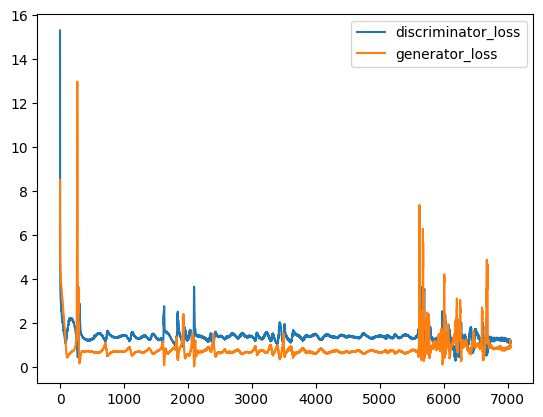

In [19]:
plt.plot(dlosses, label="discriminator_loss")
plt.plot(glosses, label="generator_loss")
# plt.ylim(0,3)
# plt.xlim(0, 1000)
plt.legend()

In [20]:
# when I increase memory units the losses go wild
# smoother losses using tanh for both activations and non-logit binary crossentropy
# not adding dropout genuinely makes it go insane

In [21]:
import scipy

In [22]:
data_features_attacks[9999-preds.shape[0]:].shape

(3200, 21, 1)

In [23]:
scipy.stats.ks_2samp(data_features_attacks[9999-preds.shape[0]:].reshape(preds.shape[0]*21,), preds.reshape(preds.shape[0]*21,))

KstestResult(statistic=0.42159226190476196, pvalue=0.0, statistic_location=0.022922636941075325, statistic_sign=1)